In [3]:
import time
import random
import numpy as np
import pandas as pd
import scipy
import scipy.stats as stats
from datetime import datetime
import matplotlib.pyplot as plt
from collections import namedtuple
import verify_bit_funcs as bid_funcs

In [3]:
num_signals = [2,5]
max_value = 100
min_value = 10
step_size = 5
max_unc = 50
num_uncs = 50/(2*step_size)

In [4]:
[stats.uniform.rvs(4500, 500, (10000,s)) for s in range(*num_signals)]

[array([[4980.22075466, 4711.83283362],
        [4971.63672403, 4570.32265954],
        [4546.77019213, 4570.23398957],
        ...,
        [4552.55550963, 4910.60379178],
        [4998.78536868, 4797.43415759],
        [4926.87652827, 4881.70157193]]),
 array([[4934.47980165, 4981.89193541, 4797.99588302],
        [4885.59049493, 4885.21595247, 4699.35778359],
        [4946.9295956 , 4693.81395007, 4833.98443697],
        ...,
        [4537.94096501, 4594.15440562, 4764.23425702],
        [4517.28734076, 4509.62997196, 4537.90052957],
        [4984.29648812, 4620.32809944, 4530.5756722 ]]),
 array([[4536.99001532, 4712.55165858, 4500.8862878 , 4803.79229703],
        [4860.75956417, 4623.26565911, 4891.74303044, 4847.49483433],
        [4860.42481823, 4677.39927377, 4894.25606757, 4913.68925459],
        ...,
        [4673.11988411, 4936.33786192, 4819.89687291, 4703.81974389],
        [4937.77170883, 4921.08964668, 4575.84380809, 4557.69807046],
        [4954.90900691, 4790.19973355

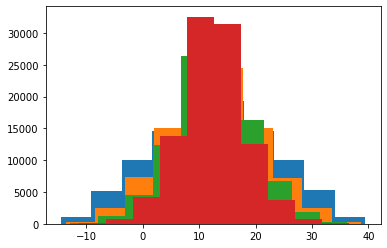

In [5]:
true = 50
signals = 2
samples = 100000
sample_signals = stats.uniform.rvs(true - max_unc/2, max_unc, (samples,signals))
sample_mids = [(max(signals)+min(signals))/2 for signals in sample_signals]
sample_uncs = [max_unc - (max(signals) - min(signals)) for signals in sample_signals]

def sample_true_value(midpoint, uncertainty, size=1):
    lower = max(midpoint - uncertainty/2, min_value)
    upper = min(midpoint + uncertainty/2, max_value)
    return stats.uniform.rvs(lower, upper - lower, size=size)


def sample_signals(true_values):
    return stats.uniform.rvs(true_values-max_unc/2, max_unc, (4, 5, len(true_values)))


def get_sufficient_stats(signal_samples, signal_set):
    sufficient_stats = []
    for i in range(len(signal_set)):
        signals = signal_samples[i,:signal_set[i],:]
        mins = np.min(signals, axis=0)
        maxs = np.max(signals, axis=0)
        uncs = max_unc - (maxs - mins)
        mids = (maxs + mins)/2
        sufficient_stats.append(np.stack((mids, uncs), axis=-1))
    return np.array(sufficient_stats)


def get_sample_data(midpoint, unc, signal_set, size):
    true_values = sample_true_value(midpoint, unc, size)
    signals = sample_signals(true_values)
    return true_values, get_sufficient_stats(signals, signal_set)

true_values, sample_data = get_sample_data(5, 20, [2,3,4,5], 100000)

for signals in range(4):
    plt.hist(sample_data[signals,:,0])

In [38]:
def joint_uniform_min_max_signal(u,v,n):
    N = np.full(np.shape(X), n)
    return scipy.special.factorial(N) * ((v - u) ** (N - 2)) / scipy.special.factorial(N - 2)

x = np.linspace(true - max_unc/2, true + max_unc/2, 1000)
y = np.linspace(true - max_unc/2, true + max_unc/2, 1000)
X,Y = np.meshgrid(x,y)

# res = []
# pdf = []

# x = []
# y = []
# for u in np.linspace(true - max_unc/2, true + max_unc/2, 1000):
#     for v in np.linspace(true - max_unc/2, true + max_unc/2, 1000):
#         res.append(joint_uniform_min_max_signal(u, v, 2) * (u + v) / 2)
#         pdf.append(joint_uniform_min_max_signal(u, v, 2))
#         x.append(u)
#         y.append(v)


(array([0.00010004, 0.00142384, 0.00844965, 0.02751637, 0.04339697,
        0.04483581, 0.02977383, 0.0093583 , 0.00173228, 0.00013838]),
 array([14.76509026, 20.76297477, 26.76085928, 32.75874379, 38.7566283 ,
        44.75451281, 50.75239732, 56.75028183, 62.74816635, 68.74605086,
        74.74393537]),
 <BarContainer object of 10 artists>)

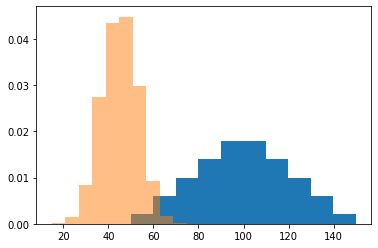

In [75]:
plt.hist(res, density=True)
plt.hist(sample_data[signals,:,0], density=True, alpha=0.5)

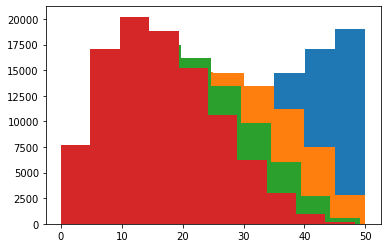

In [61]:
for signals in range(4):
    plt.hist(sample_data[signals,:,1])

In [308]:
stats.randint.pmf(9501, 500, 9501)

0.0

In [309]:
class CommonValue:
    def __init__(self, num_signals, value_range, step_size, max_unc):
        
        self.num_uncs = max_unc/step_size
        
        # why did I say this?
        if not (self.num_uncs/2).is_integer():
            raise Exception("the max uncertainty must be divisible by 2*step_size")
        
        self.num_signals = num_signals
        self.min_value, self.max_value = value_range
        self.step_size = step_size
        self.max_unc = max_unc

        ''' Generates the possible uncertainties given the parameters '''
        self.possible_uncertainty = range(0, max_unc + step_size, step_size)
        self.true_value_dist_shifted = stats.randint(value_range[0] / step_size, value_range[1]/step_size + 1)
        self.true_values = np.arange(self.min_value, self.max_value, step_size)
        self.true_probs = self.true_values/np.sum(self.true_values)
        self.m_ranges = {unc: self.possible_relative_midpoint(unc) for unc in self.possible_uncertainty}
        self.unc_prob = self.generate_unc_probs(num_signals, step_size, max_unc)
        self.Mid_unc_prob = namedtuple('Mid_unc_prob', ['mid', 'unc', 'num_signals'])
        self.mid_unc_prob_table = self.generate_mid_unc_prob_table()


        
    def prob_true(self, true_value):
        return self.true_value_dist_shifted.pmf(true_value / self.step_size)

    def prob_mid_given_unc(self, relative_mid, unc):
        mids = self.m_ranges.get(unc, [])
        return 1/len(mids) if len(mids) > 0 and relative_mid in mids else 0

    def prob_unc(self, unc, num_signals):
        #return stats.beta(num_signals - 1, 2).pdf((self.max_unc - unc)/self.max_unc)
        #return stats.betabinom.pmf(max_unc - unc, max_unc, num_signals - 1, 2)
        return self.unc_prob[num_signals].get(unc, 0)

    def prob_relative_mid_unc(self, relative_mid, unc, num_signals):
        #P(mid, unc|num_signals, uncertainty, true_value)
        return self.prob_mid_given_unc(relative_mid, unc) * self.prob_unc(unc, num_signals)

    def prob_mid_unc(self, relative_mid, unc, num_signals):
        return self.mid_unc_prob_table.get(self.Mid_unc_prob(relative_mid, unc, num_signals), 0)

    def prob_mid_unc_give_true(self, mid, unc, num_signals, true):
        if self.prob_true(true) == 0:
            return 0
        return self.prob_mid_unc(mid - true, unc, num_signals) / self.prob_true(true)


    def prob_dropouts_given_true(self, dropout_prices, true):
        """
        P(dropout prices | true) Probability of dropout prices given the true value.

        P(dropout prices | true) are conditionally independent given the true value and the state of the auction at the time that player dropped out, state_i 
        (since they only depned on iid signals).
        """
        pass

    def prob_mydrop_given_true_mystate(self, mydrop, true, mystate):
        """
        P(dropout_i | true, state_i) can be found by looking at policy function (cache of optimal decision at each state).
    
        Given state, look at each mid/unc that results in dropping out at the price they did.  Weight by P(unc,mid | true).
        Formally: P(dropout_i | true, state_i) = sum([I(dropout_i == D(state_i, mid, unc)) * P(mid, unc | true, i) for ])
    
        Parameters:
        self (object): class instance
        mydrop (binary): 1 if I drop, 0 otherwise
        true (int): true value
        mystate ()
    
        Returns:
        float: probability I take the mydrop action
    
        """
        pass

    def opp_in(state_table, policy_table, mid_unc):
        prop_opp_in_table = {signals: {} for signals in  num_signals}
        for signal in num_signals:
            for state in state_table[signal]:
                for true in range(state.mid - int(0.5 * state.unc),
                                    state.mid + int(0.5 * state.unc) + step_size,
                                    step_size):
                    p = prob_opp_in_given_true(policy_table, mid_unc, signal, state.clock_price, true)
                    prop_opp_in_table[signal][Opp_in(num_signals=signal,unc=state.unc,mid=state.mid,clock_price=state.clock_price,true_value=true)] = p
        return prop_opp_in_table

    def prob_opp_in_given_true(policy_table, mid_unc, signal, clock_price, true):
        """
        Return P(Opp_in|true) - Given a true value, I need to guess the probability that he will stay in at a state.
        {'2': 'What probability I guess about his action based on my state and my range of true value'}
        I know the true value, his #signal and current price. I must scan all possible pairs of mid_unc
        Given the true value, I get probabilities of different pairs of mid_unc
        Given a pair of mid_unc and price, I look at his policy table
        policy_table = init_policy_table
        """
        comp_signal = num_signals[~num_signals.index(signal)]
        if true not in range(min_value, max_value + step_size, step_size):
            return 0
        p = 0
        for pair in mid_unc:
            mid_unc_prob = mid_unc_prob_table[comp_signal][Mid_unc_prob(num_signals=comp_signal, unc=pair[1], mid=pair[0], true_value=true)]
            indicator = policy_table[comp_signal][State(num_signals=comp_signal,unc=pair[1],mid=pair[0],clock_price=clock_price)]
            p += mid_unc_prob * indicator

    def generate_mid_unc_prob_table(self):
        mid_unc_grid = self.mid_unc_grid()
        # mid_unc_prob_table = {s: {} for s in self.num_signals}
        mid_unc_prob_table = {}
        for signal in self.num_signals:
            for mid, unc in mid_unc_grid:
                mid_unc_prob_table[self.Mid_unc_prob(mid, unc, signal)] = self.prob_relative_mid_unc(mid, unc, signal)
            # for true in range(self.min_value, self.max_value + self.step_size, self.step_size):
            #     for mid, unc in mid_unc_grid:
            #         mid_unc_prob_table[signal][self.Mid_unc_prob(mid, unc, signal)] = self.prob_relative_mid_unc(mid, unc, signal)
        return mid_unc_prob_table

    def mid_unc_grid(self):
        mid_unc = []
        for unc in self.possible_uncertainty:
            for mid in self.m_ranges[unc]:
                mid_unc.append([mid, unc])
        return mid_unc

    def possible_relative_midpoint(self, unc):
        '''
        Given an uncertainty, we can find a set of possible midpoints as the true value is in (min_value, max_value)

        Old code below
        #return np.arange(max_unc / 2 - unc * 0.5, max_unc / 2 + unc * 0.5 + step_size, step_size)
        #return set(np.arange(self.max_unc / 2 - unc * 0.5, self.max_unc / 2 + unc * 0.5 + self.step_size, self.step_size))
        '''
        return set(np.arange(- unc * 0.5, unc * 0.5 + self.step_size, self.step_size))

    def generate_midpoints(self, unc):
        return np.arange(0, (self.max_value - self.min_value + unc) + self.step_size, self.step_size) + self.min_value - unc / 2

    def normalize_dict(self, dict):
        total_prob = sum(dict.values())
        return {k: dict[k] / total_prob for k in dict}

    def generate_unc_probs(self, num_signals, step_size, max_unc):
        unc_prob = {}
        for signals in num_signals:
            unc_dist = stats.beta(signals - 1, 2)
            unc_prob[signals] = self.normalize_dict({ u: unc_dist.pdf(1 - u / max_unc) for u in range(0, max_unc + step_size, step_size) })
        return unc_prob
    
import unittest

class TestCommonValue(unittest.TestCase):
    def setUp(self):
        self.cv = CommonValue([2,5], (10, 100), 5, 50)
    
    def test_prob_true_zero_if_outside_range(self):
        self.assertEqual(self.cv.prob_true(self.cv.min_value - self.cv.step_size), 0)
        self.assertEqual(self.cv.prob_true(self.cv.max_value + self.cv.step_size), 0)

    def test_prob_true_zero_if_between_steps(self):
        self.assertEqual(self.cv.prob_true(self.cv.min_value + self.cv.step_size/2), 0)

    def test_prob_true_constant_in_range(self):
        prob = self.cv.prob_true(self.cv.min_value)
        for t in range(self.cv.min_value + self.cv.step_size, self.cv.max_value + self.cv.step_size, self.cv.step_size):
            self.assertEqual(self.cv.prob_true(t), prob)

    def test_prob_true_sums_to_one(self):
        cumulative_prob = 0
        for t in range(self.cv.min_value, self.cv.max_value + self.cv.step_size, self.cv.step_size):
            # or use for t in self.cv.t_range?????
            cumulative_prob += self.cv.prob_true(t)
        self.assertAlmostEqual(cumulative_prob, 1)
        #self.assertEqual(cumulative_prob, 1)

    # again, whyyyy???
    def test_uncertainty_must_be_even(self):
        with self.assertRaises(Exception) as context:
            CommonValue([2,5], (10,100), 5, 51)
    
    def test_uncertainty_is_divisible_by_step(self):
        with self.assertRaises(Exception) as context:
            CommonValue([2,5], (10,100), 5, 62)

    def test_prob_unc_zero_if_outside_range(self):
        self.assertEqual(self.cv.prob_unc(-1, 2), 0)
        self.assertEqual(self.cv.prob_unc(self.cv.max_unc + 1, 2), 0)

    def test_prob_unc_zero_if_between_steps(self):
        self.assertEqual(self.cv.prob_unc(self.cv.step_size - 0.5, 2), 0)

    def test_prob_unc_sums_to_one(self):
        for signals in self.cv.num_signals:
            cumulative_prob = 0
            for unc in self.cv.possible_uncertainty:
                cumulative_prob += self.cv.prob_unc(unc, signals)
            self.assertAlmostEqual(cumulative_prob, 1)
            #self.assertEqual(cumulative_prob, 1)

    def test_prob_mid_zero_if_outside_range(self):
        self.assertEqual(self.cv.prob_mid_given_unc(-1, 30), 0)
        self.assertEqual(self.cv.prob_mid_given_unc(50, 10), 0)

    def test_prob_mid_zero_if_mid_not_possible(self):
        self.assertEqual(self.cv.prob_mid_given_unc(self.cv.max_unc / 2, 45), 0)
        
    def test_prob_mid_constant_given_unc(self):
        for unc in self.cv.possible_uncertainty:
            prob = self.cv.prob_mid_given_unc(list(self.cv.m_ranges[unc])[0], unc)
            for mid in self.cv.m_ranges[unc]:
                self.assertEqual(self.cv.prob_mid_given_unc(mid, unc), prob)

    def test_prob_mid_sums_to_one(self):
        for unc in self.cv.possible_uncertainty:
            cumulative_prob = 0
            for mid in self.cv.possible_relative_midpoint(unc):
                cumulative_prob += self.cv.prob_mid_given_unc(mid, unc)
            self.assertAlmostEqual(cumulative_prob, 1) 
            #self.assertEqual(cumulative_prob, 1)

    def test_prob_relative_mid_unc_sums_to_one(self):
        mid_unc = self.cv.mid_unc_grid()
        
        for signals in self.cv.num_signals:
            self.assertAlmostEqual(sum([self.cv.prob_relative_mid_unc(mid, unc, signals) for mid, unc in mid_unc]), 1)

    def test_prob_mid_unc_sums_to_one(self):
        mid_unc = self.cv.mid_unc_grid()
        
        for signals in self.cv.num_signals:
            self.assertAlmostEqual(sum([self.cv.prob_mid_unc(mid, unc, signals) for mid, unc in mid_unc]), 1)

    
    

In [310]:
unittest.main(argv=[''], exit=False)

...............
----------------------------------------------------------------------
Ran 15 tests in 0.081s

OK


In [402]:
def possible_midpoint(true_value, unc):
    #Given an uncertainty, we can find a set of possible midpoints as the true value is in (min_value, max_value)
    possible_midpoint = [i for i in range(true_value - int(unc * 0.5), true_value + int(unc * 0.5) + step_size, step_size)]
    return possible_midpoint

In [403]:
def prob_midpoint(true_value, mid, unc):
    #Return P(mid|num_signals, uncertainty, true_value)
    #Midpoint is uniformly drawn from the possible midpoint given an uncertainty
    if mid in possible_midpoint(true_value, unc):
        return 1/len(possible_midpoint(true_value, unc))
    else:
        return 0

In [8]:
def prob_unc(unc, num_signals):
    #Return P(unc|true_value, num_signals)
    #Uncertainty follows a Beta distribution
    #uncs = np.linspace(min_value, max_unc + 2 * step_size, num_uncs + 1)
    uncs = np.linspace(0, max_unc, num_uncs + 1)
    unc_dist = stats.beta(num_signals-1, 2)
    #unc_likes = unc_dist.pdf(1 - uncs/(max_unc + 2 * step_size))/(max_unc + 2 * step_size)
    unc_likes = unc_dist.pdf(1 - uncs/max_unc)
    unc_probs = unc_likes/np.sum(unc_likes)
    uncs_index = uncs.tolist().index(unc)
    return unc_probs[uncs_index]

In [287]:
t_value_dist = stats.randint(500, 9500)

In [293]:
rand_values = np.arange(0, 10000, 1)

%timeit [t_value_dist.pmf(v) for v in rand_values]

786 ms ± 16.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [294]:
t_values = range(500, 9501)

def pmf_true(v):
    return 1/9000 if v in t_values else 0

%timeit [pmf_true(v) for v in rand_values]

4.14 s ± 313 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [157]:
cv = CommonValue([2,3,4,5], [500, 9500], 1, 500)
%timeit [cv.prob_relative_mid_unc(mid, unc, signals) for unc in range(0, cv.max_unc, cv.step_size) for mid in range(int(0 - cv.max_unc / 2), int(cv.max_unc / 2) + cv.step_size, cv.step_size) for signals in cv.num_signals]
%timeit [cv.prob_relative_mid_unc(mid, unc, signals) for unc in range(0, cv.max_unc + cv.step_size, cv.step_size) for mid in cv.m_ranges[unc] for signals in cv.num_signals]

611 ms ± 7.28 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
302 ms ± 27.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [191]:
cv = CommonValue([2,3,4,5], [500, 9500], 1, 500)
%timeit [cv.prob_mid_unc(mid, unc, signals) for unc in range(0, cv.max_unc, cv.step_size) for mid in range(int(0 - cv.max_unc / 2), int(cv.max_unc / 2) + cv.step_size, cv.step_size) for signals in cv.num_signals]
%timeit [cv.prob_mid_unc(mid, unc, signals) for unc in range(0, cv.max_unc + cv.step_size, cv.step_size) for mid in cv.m_ranges[unc] for signals in cv.num_signals]

496 ms ± 7.93 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
263 ms ± 2.16 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [195]:
cv = CommonValue([2,3,4,5], [500, 9500], 1, 500)

In [9]:
def prob_mid_unc(true_value, mid, unc, num_signals):
    #P(mid, unc|num_signals, uncertainty, true_value)
    return prob_midpoint(true_value, mid, unc) * prob_unc(unc, num_signals)

In [43]:
cv = CommonValue([2,3,4,5], [10, 100], 1, 50)

mid_unc = []
for unc in range(0, cv.max_unc + cv.step_size, cv.step_size):
    for mid in cv.m_ranges[unc]:
      mid_unc.append([mid, unc])
sum([cv.prob_mid_unc(mid, unc, 2) for mid, unc in mid_unc])

0.9999999999999987

# Grid Approximation attempt 2

Im not sure if this is the correct way to approach this.  The CommonValue class uses discrete values for midpoints but this uses continuous uniform distribution for midpoints instead.  However, the p(mid, unc) do not match when using only actually possible midpoints.  

In [92]:
def prob_mid_cont(mid, unc, max_unc):
    if unc == 0:
        return 1 if mid == max_unc / 2 else 0
        
    return 1/unc if mid >= (max_unc - unc) / 2 and mid <= (max_unc + unc)/2 else 0

def prob_unc_cont(unc, signals, max_unc):
    return stats.beta(signals - 1, 2).pdf(1 - unc/max_unc)

def prob_mid_unc_cont(mid, unc, signals, max_unc):
    return prob_mid_cont(mid, unc, max_unc) * prob_unc_cont(unc, signals, max_unc)

cv = CommonValue([2,3,4,5], [10, 100], 1, 50)
mid_unc = []
for unc in range(0, cv.max_unc + cv.step_size, cv.step_size):
    for mid in cv.m_ranges[unc]:
      mid_unc.append([mid, unc])

scale = sum([prob_mid_unc_cont(mid, unc, 2, cv.max_unc) for mid, unc in mid_unc])
pmu = {(mid, unc): prob_mid_unc_cont(mid, unc, 2, cv.max_unc) / scale for mid, unc in mid_unc}

In [101]:
print(cv.prob_mid_unc(22, 6, 2))
print(pmu[(22, 6)])
print(f'{sum(pmu.values())} vs {sum([cv.prob_mid_unc(mid, unc, 2) for mid, unc in pmu.keys()])}')

0.0006722689075630253
0.0007547169811320893
0.9999999999999997 vs 0.9999999999999987


In [11]:
#Return P(mid, unc|true) - given a true value, what is the probability of a pair of mid and unc?

# mid_unc_prob_table = {num_signals[0]: {}, num_signals[1]: {}}
# for signal in num_signals:
#     for unc in range(min_value, max_unc + 2 * step_size, 2 * step_size):
#         for mid in range(min_mid, max_mid + step_size, step_size):
#             for true in range(min_value, max_value + step_size, step_size):
#               mid_unc_prob_table[signal][Mid_unc_prob(signal, unc, mid, true)] = prob_mid_unc(true_value=true,mid=mid, unc=unc, num_signals=signal)

# DP

I think this is where Steve started implementing the DP

In [102]:
State = namedtuple('State', ['unc', 'mid', 'clock_price'])
Opp_in = namedtuple('Opp_in', ['unc', 'mid', 'clock_price', 'true_value'])
True_prob = namedtuple('True_prob', ['unc', 'mid', 'clock_price', 'true_value'])

In [103]:
#Return P(mid, unc|true) - given a true value, what is the probability of a pair of mid and unc?


mid_unc_prob_table = {num_signals[0]: {}, num_signals[1]: {}}
for signal in num_signals:
  for true in range(min_value, max_value + step_size, step_size):
    for pair in mid_unc:
      mid_unc_prob_table[signal][Mid_unc_prob(signal, pair[1], pair[0], true)] = prob_mid_unc(true_value=true, mid=pair[0], unc=pair[1], num_signals=signal)

NameError: name 'num_signals' is not defined

In [48]:
sample = [min(random.choices([1,2,3,4,5], k=2)) for _ in range(1000000)]
print(f'sample: {sum([v < 3 for v in sample])/len(sample)} vs analytic {16/25}')

sample: 0.640046 vs analytic 0.64


In [13]:
state_table = {num_signals[0]: [], num_signals[1]: []}
#value iteration - generate random value table and policy table at the beginning
init_value_table = {num_signals[0]: {}, num_signals[1]: {}}
init_policy_table = {num_signals[0]: {}, num_signals[1]: {}}
for signal in num_signals:
    for unc in range(min_value, max_unc + 2 * step_size, 2 * step_size):
        for mid in range(min_mid, max_mid + step_size, step_size):
            for price in range(min_value - step_size, max_value + step_size, step_size):
                state_table[signal].append(State(signal, unc, mid, price))
                init_value_table[signal][State(signal, unc, mid, price)] = max(mid - price,0) #initialy, a player drops when clock price approaches hid midpoint. Thus, his value is zero for all prices over his midpoint 
                init_policy_table[signal][State(signal, unc, mid, price)] = 1 if mid >= price else 0
                #init_value_table[signal][State(signal, unc, mid, price)] = max(mid + 0.5 * unc - price,0) #initialy, a player drops when clock price approaches hid midpoint. Thus, his value is zero for all prices over his midpoint 
                #init_policy_table[signal][State(signal, unc, mid, price)] = 1 if (mid + int(0.5 * unc)) >= price else 0

# Counting number of states

In [259]:
max_value = 950
min_value = 50
d = 5
a = (max_value - min_value) / d + 1
n = 100 / d + 1
clock_increment = 10
clock_prices = (max_value - min_value) / clock_increment

min_unc_count = n / 2 * (2 * a + (n - 1))
min_unc_count * 4 * clock_prices * clock_prices**3

1052646840000.0

In [236]:
cv2 = CommonValue([2,3,4,5], [10, 100], 5, 50)
all_mids2 = {(m + t, unc) for t in range(cv2.min_value, cv2.max_value + cv2.step_size, cv2.step_size) for unc in cv2.possible_uncertainty for m in cv2.possible_relative_midpoint(unc)}
len(all_mids2)

264

In [14]:
def transition_matrix(state, policy_table, decision_table):
    #Return a matrix: [[In-In, Out-In], [In-Out, Out-Out]]
    #It's a subjective transition matrix. Given a state, I know my decision and need to guess his decision
    p1 = policy_table[state.num_signals][state]
    p2 = decision_table[state.num_signals][state]

    decision1 = np.array([p1, 1 - p1])
    decision2 = np.array([p2, 1 - p2]).reshape(2,1)
    trans_matrix = decision1 * decision2
    return trans_matrix

In [15]:
def expected_value(state, true_value_dist_table):
    total = 0
    for true in range(state.mid - int(0.5 * state.unc),
                      state.mid + int(0.5 * state.unc) + step_size,
                      step_size):
      if true in range(min_value, max_value + step_size, step_size):
        total += ((true - state.clock_price) * 
                  true_value_dist_table[state.num_signals][True_prob(state.num_signals, state.unc, state.mid, state.clock_price, true)])
    return total

In [62]:
#Return P(Opp_in|true) - Given a true value, I need to guess the probability that he will stay in at a state.
#{'2': 'What probability I guess about his action based on my state and my range of true value'}
#I know the true value, his #signal and current price. I must scan all possible pairs of mid_unc
#Given the true value, I get probabilities of different pairs of mid_unc
#Given a pair of mid_unc and price, I look at his policy table
#policy_table = init_policy_table

def opp_in(state_table, policy_table, mid_unc):
  prop_opp_in_table = {num_signals[0]: {}, num_signals[1]: {}}
  for signal in num_signals:
    for state in state_table[signal]:
      for true in range(state.mid - int(0.5 * state.unc),
                        state.mid + int(0.5 * state.unc) + step_size,
                        step_size):
          p = prob_opp_in_given_true(policy_table, mid_unc, signal, state.clock_price, true)
          prop_opp_in_table[signal][Opp_in(num_signals=signal,unc=state.unc,mid=state.mid,clock_price=state.clock_price,true_value=true)] = p
  return prop_opp_in_table

def prob_opp_in_given_true(policy_table, mid_unc, signal, clock_price, true):
    comp_signal = num_signals[~num_signals.index(signal)]
    if true not in range(min_value, max_value + step_size, step_size):
        return 0
    p = 0
    for pair in mid_unc:
        mid_unc_prob = mid_unc_prob_table[comp_signal][Mid_unc_prob(num_signals=comp_signal, unc=pair[1], mid=pair[0], true_value=true)]
        indicator = policy_table[comp_signal][State(num_signals=comp_signal,unc=pair[1],mid=pair[0],clock_price=clock_price)]
        p += mid_unc_prob * indicator

In [63]:
#Return P(true|state)

def true_value_dist(state_table, prop_opp_in_table):
  true_value_dist_table = {num_signals[0]: {}, num_signals[1]: {}}
  for signal in num_signals:
    comp_signal = num_signals[~num_signals.index(signal)]
    for state in state_table[signal]:
      t = {}
      for true in range(state.mid - int(0.5 * state.unc),
                        state.mid + int(0.5 * state.unc) + step_size,
                        step_size):
        if true in range(min_value, max_value + step_size, step_size):
          price = state.clock_price
          if state.clock_price > min_value:
            price -= step_size
          t[True_prob(signal,state.unc,state.mid,state.clock_price,true)] = (mid_unc_prob_table[signal][Mid_unc_prob(signal,state.unc,state.mid,true)] *
                                                                             prob_true(true) *
                                                                             prop_opp_in_table[comp_signal][Opp_in(comp_signal,state.unc,state.mid,price,true)])
      if not all(x == 0 for x in list(t.values())):
        t = {k: v/total for total in (sum(t.values()),) for k, v in t.items()}
      true_value_dist_table[signal].update(t)
  return true_value_dist_table

In [64]:
opp_table = opp_in(state_table, init_policy_table, mid_unc)

In [19]:
#Return P(decision|state) - decisions of competitors
#{'2': what a player with 2 signals think about the decision of the other player with 5 signals at a state}
#given a state, I know my decision based on my policy table, but I need to guess his decision
#I scan all possible true values with my true value distribution. Given these true values, I compute his probability of staying in given a true value and the state's price

def decision(state_table, prop_opp_in_table, true_value_dist_table):
  decision_table = {num_signals[0]: {}, num_signals[1]: {}}
  for signal in num_signals:
    comp_signal = num_signals[~num_signals.index(signal)]
    for state in state_table[signal]:
      d = 0
      for true in range(state.mid - int(0.5 * state.unc),
                        state.mid + int(0.5 * state.unc) + step_size,
                        step_size):
        if true in range(min_value, max_value + step_size, step_size):
          prob_dec = prop_opp_in_table[comp_signal][Opp_in(comp_signal,state.unc,state.mid,state.clock_price,true)]
          prob_tr = true_value_dist_table[signal][True_prob(state.num_signals,state.unc,state.mid,state.clock_price,true)]
          d += prob_dec * prob_tr
      decision_table[signal][state] = d
  return decision_table

In [21]:
start_time = datetime.now()
policy_table = init_policy_table
value_table = init_value_table

done = False
table = {}
# while not done:

for _ in range(2):  
  prop_opp_in_table = opp_in(state_table, init_policy_table, mid_unc)
  true_value_dist_table = true_value_dist(state_table, prop_opp_in_table)
  decision_table = decision(state_table,prop_opp_in_table,true_value_dist_table)

  for signal in num_signals:
    comp_signals = num_signals[~num_signals.index(signal)]
    delta = [0 for _ in range(len(state_table[signal]))]
    for i in range(len(state_table[signal])-1,-1,-1):
      state = state_table[signal][i]
      init_value = value_table[signal][state]

      exp_value = expected_value(state, true_value_dist_table)
      trans_matrix = transition_matrix(state,policy_table,decision_table)

      if state.clock_price < max_value:
        if (state.mid + 0.5 * state.unc) >= state.clock_price + step_size:
          val_out = trans_matrix[1][1] * exp_value * 0.5
          val_in = trans_matrix[1][0] * exp_value + trans_matrix[0][0] * value_table[signal][state_table[signal][i+1]]
          value_table[signal][state] = max(val_out, val_in)
          policy_table[signal][state] = 1 if val_in > val_out else 0
        else:
          val_out = val_in = exp_value * 0.5 * (decision_table[signal][state])
          value_table[signal][state] = val_in
          policy_table[signal][state] = 0
      else:
        value_table[signal][state] = 0
        policy_table[signal][state] = 0

      delta[i] = max(delta[i], abs(init_value - value_table[signal][state]))

    table[signal] = delta


  # theta = 0.5
  # if (all(x < theta for x in table[2])) and (all(y < theta for y in table[5])):
  #   done = True
  # else:
  #   done = False

end_time = datetime.now()
print(f'The execution time is {end_time - start_time}, from {start_time} to {end_time} ')

The execution time is 0:00:09.987923, from 2021-09-02 15:30:00.720666 to 2021-09-02 15:30:10.708589 


...
----------------------------------------------------------------------
Ran 3 tests in 0.001s

OK
